In [203]:
#Vehicle.py

import numpy as np

""" I define the integration functions outside of the class and pass which integrator to use as an argument at instantiation. """
def RK4(x0, f, h, u, t=0):
    k1 = h * f(x0, u, t)
    k2 = h * f(x0 + k1/2, u, t + h / 2)
    k3 = h * f(x0 + k2/2, u, t + h / 2)
    k4 = h * f(x0 + k3, u, t + h)
    return x0 + (k1 + 2*k2 + 2*k3 + k4)*h/6

def ForwardEuler(x0, f, h, u, t=0):
    return x0 + h * f(x0, u, t)

def ImprovedForwardEuler(x0, f, h, u, t=0):
    k1 = f(x0, u, t)
    k2 = f(x0 + h*k1, u, t + h)
    return x0 + (h/2)*(k1 + k2)

class BikeVehicle:

    def __init__(self, WHEEL_RAD = 3, HALF_WHEEL_BASE_WIDTH = 5, WHEEL_BASE_LENGTH = 20,MOTOR_C = 5*np.pi, STEERING_C = 5, numIntFunc = ForwardEuler):
        self.wheelRadius = WHEEL_RAD
        self.wheelBaseWidth = HALF_WHEEL_BASE_WIDTH #distance of left wheel to right wheel
        self.wheelBaseLength = WHEEL_BASE_LENGTH #distance of front wheel to back wheel
        self.motorConst = MOTOR_C
        self.steeringConst = STEERING_C
        self.numIntFunc = numIntFunc

        """We use the reset method to create the states of the system and vectors to log state trajectories"""
        self.reset()

    def reset(self):
        """The state of the robot in world coordinates (X,Y,Theta), and the derivative of states (dX, dY, dTheta).
        These are the states of the robot in world coordinates."""
        self.state = np.zeros(3)
        self.dState = np.zeros(3)

        """These are the velocities of the robot in robot coordinates. 
        Note, there is no dy since the robot may not move sideways, but you may add one if you choose to vectorize the equation."""
        self.dTheta = 0
        self.dx = 0

        """A vector to store state and velocity vectors of simulations."""
        self.trajLog = np.empty([3,1])
        self.velLog = np.empty([2,1])


    def motorToWheelVel(self, motorInput):
        vel_RWD = self.wheelRadius*self.motorConst*motorInput[0]   #v = r*w, MI[0]: for RWD motor
        ack_angle = self.steeringConst*motorInput[1]               #MI[1]: for steering angle
        return (vel_RWD, ack_angle)

    """Calc vehicle frame velocities without saving to vehicle attributes"""
    #Inverse Kinematics
    def calcVelocities(self, motorInput): 
        vel_RWD, ack_angle = self.motorToWheelVel(motorInput)
        dx = vel_RWD
        dTheta = vel_RWD*np.tan(ack_angle)/(self.wheelBaseLength)
        return (dx, dTheta)

    """Update vehicle attributes"""
    def updateVelocities(self, motorInput):
        self.dx, self.dTheta = self.calcVelocities(motorInput)
        return [self.dx, self.dTheta]

    """We need q as the state input (rather than just self.state) for the intermediate calculations in RK4"""
    """This f is the f we'll pass to the numerical integration function. Add code here"""
    def f(self, q, motorInput, t=0):
        dx, dTheta = self.calcVelocities(motorInput)
        x_dot = dx*(np.cos(q[2]))
        y_dot = dx*(np.sin(q[2]))
        dState = np.array([x_dot, y_dot, dTheta])
        return dState

    def updateDState(self, motorInput):
        self.dState = self.f(self, motorInput)

    """
    We create vectors to log the states and velocities in our simulation.
    We want the log to accommodate the initial state and all the steps prescribed in motorInput, hence these vectors have motorInput.shape[1]+1 columns
    """
    
    """ Write initial condition as first state in trajLog. """
    
    """ Step through simulation and log results. You write this loop"""
    def sim(self, state_0, h, motorInput):
        self.trajLog = np.zeros((3, motorInput.shape[1]+1))
        self.velLog = np.zeros((2, motorInput.shape[1]+1))
        self.trajLog[:, 0] = state_0
        
        for k, MI in enumerate(np.transpose(motorInput)):
            if k > 0:
                self.trajLog[:,k] = self.numIntFunc(self.trajLog[:,k-1],self.f ,h,MI)
                self.velLog[:,k] = self.updateVelocities(MI)
    
    def motorInputsList(self,v,w):
        MI_1 = v/(self.wheelRadius*self.motorConst)                                                         #Motor Input for forward velocity of vehicle
        MI_2 = np.arctan2(self.wheelBaseLength*w, MI_1*self.wheelRadius*self.motorConst)/self.steeringConst #Motor Input for forward velocity of vehicle
        return (MI_1,MI_2)
    
    def printVehicleTrajectory(self):
        plt.plot(self.trajLog[0][3:],self.trajLog[1][3:])

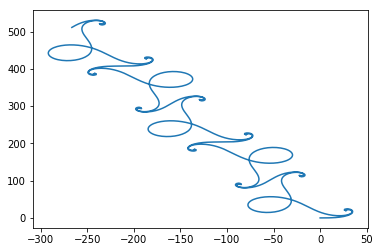

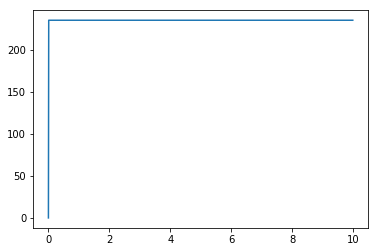

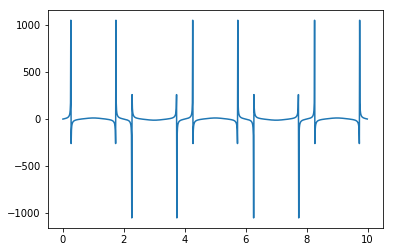

In [185]:
#simVehicle.py

import numpy as np
import matplotlib.pyplot as plt

""" I use cm and gridspec for colormaps and subplots. You don't need to. """
import matplotlib.cm as cm
import matplotlib.gridspec as gs

""" Create mbot """
mbot = BikeVehicle(numIntFunc=ForwardEuler)

""" Simulation duration and time steps and inputs. """
duration = 10

""" Using lambda functions to create motor input arrays. Row 0 = right motor, Row 1 = left motor. """
motorInputs = lambda T: np.array([5*np.ones_like(T),(np.pi/4)*np.sin(0.25*2*np.pi*T)])
h = 0.01

t = np.arange(0, duration, h, dtype=float)

MI = motorInputs(t)

state_0 = np.array([0,0,0])

mbot.reset()
mbot.sim(state_0, h, MI)

plt.plot(mbot.trajLog[0][:t.size],mbot.trajLog[1][:t.size])
plt.show()
plt.plot(t, mbot.velLog[0,:t.size], label='dx')
plt.show()
plt.plot(t, mbot.velLog[1,:t.size], label='dTheta')

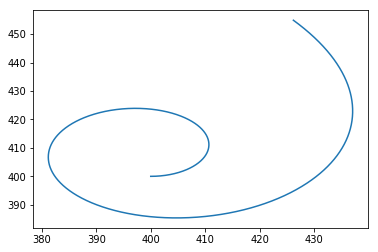

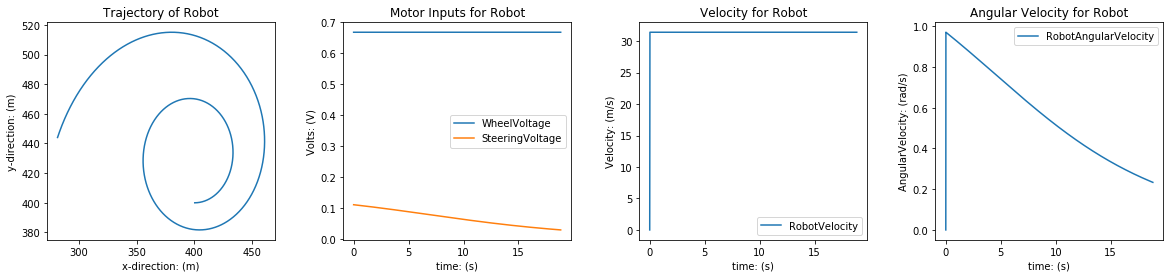

In [186]:
dt = 0.01
t = np.arange(0, 6*np.pi, dt)
x = np.array(np.zeros((t.size,1)))
y = np.array(np.zeros((t.size,1)))
theta = np.array(np.zeros((t.size,1)))

x0 = 400
y0 = 400
theta0 = 0

v = 10*np.ones((t.size))

w = np.e**(-0.1*t)

for i in range(t.size):
    if i == 0:
        x[i] = x0
        y[i] = y0
        theta[i] = theta0
    else:
        x[i] = x[i-1] + v[i]*np.cos(theta[i-1])*dt
        y[i] = y[i-1] + v[i]*np.sin(theta[i-1])*dt
        theta[i] = theta[i-1] + w[i]*dt
plt.plot(x,y)
plt.show()
t.size

Kv = 5 #Motor Constant
Ks = 10 #Steering Constant
b = 5 #wheelBaseWidth
r = 3 #wheelRadius
L = 20 #wheelBaseLength = 20

u1 = v/(r*Kv)
u2 = np.arctan2(L*w, u1*r*Kv)/Ks

MotorInputs = np.array([u1,u2])

state_0 = [x0,y0,theta0]

mbot.reset()
mbot.sim(state_0, dt, MotorInputs)

fig , axs = plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
axs[0].plot(mbot.trajLog[0][1:t.size], mbot.trajLog[1][1:t.size], '-',label='trajectory')

axs[0].set_title('Trajectory of Robot')
axs[0].set_xlabel('x-direction: (m)')
axs[0].set_ylabel('y-direction: (m)')

axs[1].plot(t,MotorInputs[0], '-',label='WheelVoltage')
axs[1].plot(t,MotorInputs[1], '-',label='SteeringVoltage')
axs[1].set_title('Motor Inputs for Robot')
axs[1].set_xlabel('time: (s)')
axs[1].set_ylabel('Volts: (V)')
axs[1].legend()

axs[2].plot(t, mbot.velLog[0,:t.size], label='RobotVelocity')
axs[2].set_title('Velocity for Robot')
axs[2].set_xlabel('time: (s)')
axs[2].set_ylabel('Velocity: (m/s)')
axs[2].legend()

axs[3].plot(t, mbot.velLog[1,:t.size], label='RobotAngularVelocity')
axs[3].set_title('Angular Velocity for Robot')
axs[3].set_xlabel('time: (s)')
axs[3].set_ylabel('AngularVelocity: (rad/s)')
axs[3].legend()

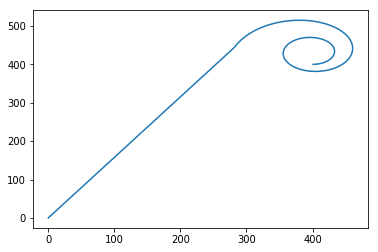

In [187]:
mbot.printVehicleTrajectory()

In [188]:
from vehicle import *

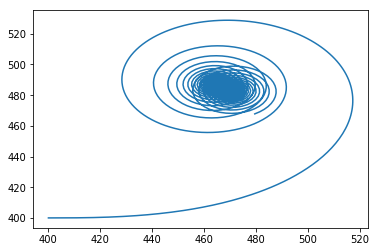

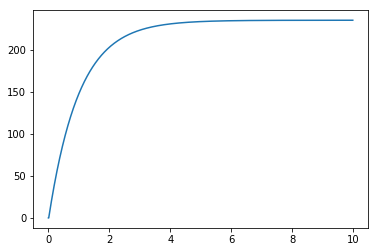

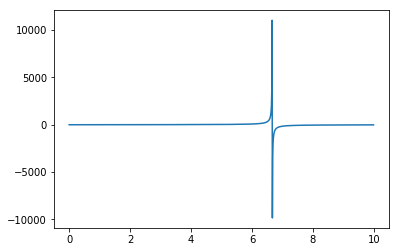

In [189]:
#Low-Pass Filter
#simVehicle.py
dt = 0.01
t = np.arange(0, 6*np.pi, dt)
x = np.array(np.zeros((t.size,1)))
y = np.array(np.zeros((t.size,1)))
theta = np.array(np.zeros((t.size,1)))

x0 = 400
y0 = 400
theta0 = 0

v = 10*np.ones((t.size))

w = np.e**(-0.1*t)

for i in range(t.size):
    if i == 0:
        x[i] = x0
        y[i] = y0
        theta[i] = theta0
    else:
        x[i] = x[i-1] + v[i]*np.cos(theta[i-1])*dt
        y[i] = y[i-1] + v[i]*np.sin(theta[i-1])*dt
        theta[i] = theta[i-1] + w[i]*dt
#plt.plot(x,y)
#plt.show()
t.size

Kv = 5*np.pi #Motor Constant
Ks = 5 #Steering Constant
b = 5 #wheelBaseWidth
r = 3 #wheelRadius
L = 10 #wheelBaseLength = 20

u1 = v/(r*Kv)
u2 = np.arctan2(L*w, u1*r*Kv)/Ks

MotorInputs = np.array([u2,u1])
import numpy as np
import matplotlib.pyplot as plt

""" I use cm and gridspec for colormaps and subplots. You don't need to. """
import matplotlib.cm as cm
import matplotlib.gridspec as gs

""" Create mbot """
mbot = BikeVehicle(numIntFunc=RK4)

""" Simulation duration and time steps and inputs. """
duration = 10

""" Using lambda functions to create motor input arrays. Row 0 = steering motor, Row 1 = rear wheel motor,  """
motorInputs = lambda T: np.array([(np.pi/4)*np.sin(0.01*2*np.pi*T), 5*np.ones_like(T)])
# motorInputs = lambda T: np.array([np.zeros_like(T),3.3*np.ones_like(T)])
# motorInputs = lambda T: np.array([np.zeros_like(T),np.ones_like(T)])

h = 0.01

t = np.arange(0, duration, h, dtype=float)

MI = motorInputs(t)

state_0 = np.array([400,400,0,0,0])

mbot.reset()
mbot.sim(state_0, h, MI)

plt.plot(mbot.stateLog[0][:t.size],mbot.stateLog[1][:t.size])
plt.show()
plt.plot(t, mbot.velLog[0][:t.size], label='dx')
plt.show()
plt.plot(t, mbot.velLog[1][:t.size], label='dTheta')

# for i in range(0, mbot.stateLog.shape[1]):
#     print(mbot.stateLog[0][i],mbot.stateLog[1][i])

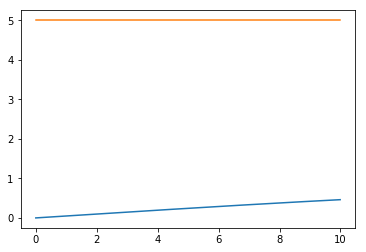

In [190]:
plt.plot(t,MI[0])
plt.plot(t,MI[1])

In [195]:
motorInputs = lambda T: np.array([5*np.ones_like(T),(np.pi/4)*np.sin(0.25*2*np.pi*T)])

In [222]:
x0 = 400
y0 = 400
theta0 = 0.0

v = 10*np.ones((t.size))

w = np.e**(-0.1*t)

for i in range(t.size):
    if i == 0:
        x[i] = x0
        y[i] = y0
        theta[i] = theta0
    else:
        x[i] = x[i-1] + v[i]*np.cos(theta[i-1])*dt
        y[i] = y[i-1] + v[i]*np.sin(theta[i-1])*dt
        theta[i] = theta[i-1] + w[i]*dt
        
class Trajectory:

    def __init__(self, INIT_X=0.0, INIT_Y=0.0, INIT_THETA=0.0):
        self.x0 = INIT_X
        self.y0 = INIT_Y
        self.theta0 = INIT_THETA
        self.reset()
        
    def reset(self):
        self.trajLog = np.empty([3,1])
        
    def newTraj(self,x0,y0,theta0):
        self.x0 = x0
        self.y0 = y0
        self.theta0 = theta0
        
    def simulateTrajectory(self,v,w,t):
        self.trajLog = np.zeros((3, t.shape[0]))
        self.trajLog[:,0] = np.array([self.x0,self.y0,self.theta0])
        
        dt = t[2] - t[1]
        for i in range(1,t.shape[0]):
            self.trajLog[0,i] = self.trajLog[0,i-1] + v[i]*np.cos(self.trajLog[2,i-1])*dt
            self.trajLog[1,i] = self.trajLog[1,i-1] + v[i]*np.sin(self.trajLog[2,i-1])*dt
            self.trajLog[2,i] = self.trajLog[2,i-1] + w[i]*dt
        
        

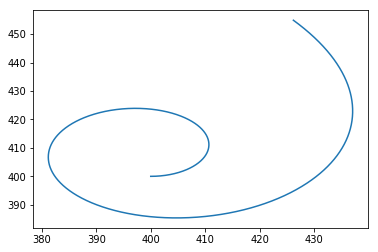

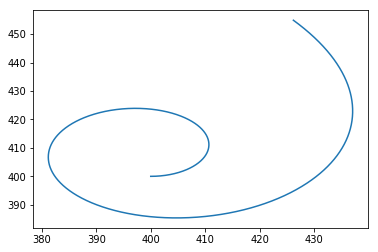

In [223]:
dt = 0.01

t = np.arange(0, 6*np.pi, dt)
v = 10*np.ones((t.size))
w = np.e**(-0.1*t)

traj = Trajectory(400.0,400.0,0.0)
traj.reset()

traj.simulateTrajectory(v,w,t)

plt.plot(traj.trajLog[0],traj.trajLog[1])
plt.show()
plt.plot(x,y)

In [199]:
motorInputs = lambda T: np.array([(np.pi/4)*np.sin(0.01*2*np.pi*T), 5*np.ones_like(T)])
Mot = motorInputs(t)
 """These are the velocities of the robot in robot coordinates. 
        Note, there is no dy since the robot may not move sideways, but you may add one if you choose to vectorize the equation."""
        self.dTheta = 0
        self.dx = 0

        """A vector to store state and velocity vectors of simulations."""
        self.trajLog = np.empty([3,1])
        self.velLog = np.empty([2,1])
for k, MI in enumerate(np.transpose(Mot)):
    print(k,MI[0],MI[0])



IndentationError: unexpected indent (<ipython-input-199-bfbaad50d47f>, line 3)

In [201]:
a = np.zeros([10,1])
for i in range(0,len(a)):
    print(a[i])

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [1]:
import os
os.path.abspath(os.getcwd())

'/Users/chitobadillo/Desktop'